# Recommendations with IBM
2020/3/17

In this notebook, I will use real data from the IBM Watson Studio platform to built recommendation systems.

## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>
V. [Concluding](#conclusions)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null float64
title         45993 non-null object
email         45976 non-null object
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


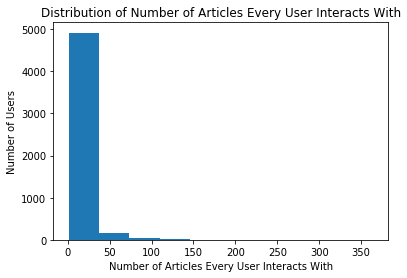

In [4]:
dist = df.groupby(['email']).count()['article_id']
plt.hist(dist);
plt.xlabel('Number of Articles Every User Interacts With');
plt.ylabel('Number of Users');
plt.title('Distribution of Number of Articles Every User Interacts With');

In [5]:
df.groupby(['email']).nunique().median()

article_id    3.0
title         3.0
email         1.0
dtype: float64

In [6]:
df.groupby(['email']).count().max()

article_id    364
title         364
dtype: int64

In [7]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user =364  # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [8]:
# Find and explore duplicate articles
df_content.drop_duplicates(inplace=True)
df_content.duplicated().sum()

0

In [9]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset = 'article_id',keep = 'first',inplace = True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [10]:
df['article_id'].nunique()

714

In [11]:
df.columns

Index(['article_id', 'title', 'email'], dtype='object')

In [12]:
df['email'].nunique()

5148

In [13]:
df_content['article_id'].nunique()

1051

In [14]:
df.shape

(45993, 3)

In [15]:
unique_articles =714 # The number of unique articles that have at least one interaction
total_articles =1051  # The number of unique articles on the IBM platform
unique_users =5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [16]:
maxvalue = df.groupby('article_id').count()['email'].max()
print(maxvalue)
df.groupby('article_id').count()['email'][df.groupby('article_id').count()['email'] == maxvalue]

937


article_id
1429.0    937
Name: email, dtype: int64

In [17]:
most_viewed_article_id = str(1429.0) # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [18]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [19]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [20]:
article_ids = df.groupby('title').count().sort_values('user_id',ascending=False).iloc[:10].index
#article_ids = list(article_ids)
np.array(article_ids)

array(['use deep learning for image classification',
       'insights from new york car accident reports',
       'visualize car data with brunel',
       'use xgboost, scikit-learn & ibm watson machine learning apis',
       'predicting churn with the spss random tree algorithm',
       'healthcare python streaming application demo',
       'finding optimal locations of new store using decision optimization',
       'apache spark lab, part 1: basic concepts',
       'analyze energy consumption in buildings',
       'gosales transactions for logistic regression model'], dtype=object)

In [21]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = df.groupby('title').count().sort_values('user_id',ascending=False).iloc[:n].index
    top_articles = list(top_articles)
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = df.groupby('article_id').count().sort_values('user_id',ascending=False).iloc[:n].index
    top_articles = list(top_articles)
    return top_articles # Return the top article ids

In [22]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [23]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [24]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    change1 = lambda x : 1 if x > 0 else 0
    user_item = df.groupby(["user_id","article_id"]).count().unstack().applymap(change1)

    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [25]:
user_item.head()

title                                                          \
article_id 0.0    2.0    4.0    8.0    9.0    12.0   14.0   15.0   16.0     
user_id                                                                     
1               0      0      0      0      0      0      0      0      0   
2               0      0      0      0      0      0      0      0      0   
3               0      0      0      0      0      1      0      0      0   
4               0      0      0      0      0      0      0      0      0   
5               0      0      0      0      0      0      0      0      0   

                   ...                                                   \
article_id 18.0    ... 1434.0 1435.0 1436.0 1437.0 1439.0 1440.0 1441.0   
user_id            ...                                                    
1               0  ...      0      0      1      0      1      0      0   
2               0  ...      0      0      0      0      0      0      0   
3               0  ...      0      0      1      0      0      0      0   
4               0  ...      0      0      0      0      0      0      0   
5               0  ...      0      0      0      0      0      0      0   

                                 
article_id 1442.0 1443.0 1444.0  
user_id                          
1               0      0      0  
2               0      0      0  
3               0      0      0  
4               0      0      0  
5               0      0      0  

[5 rows x 714 columns]

In [26]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [27]:
user_item.head(1)

title                                                          \
article_id 0.0    2.0    4.0    8.0    9.0    12.0   14.0   15.0   16.0     
user_id                                                                     
1               0      0      0      0      0      0      0      0      0   

                   ...                                                   \
article_id 18.0    ... 1434.0 1435.0 1436.0 1437.0 1439.0 1440.0 1441.0   
user_id            ...                                                    
1               0  ...      0      0      1      0      1      0      0   

                                 
article_id 1442.0 1443.0 1444.0  
user_id                          
1               0      0      0  

[1 rows x 714 columns]

In [28]:
user_item.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5149 entries, 1 to 5149
Columns: 714 entries, (title, 0.0) to (title, 1444.0)
dtypes: int64(714)
memory usage: 28.2 MB


In [29]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    user_idx = user_item.index.get_loc(user_id)
    # compute similarity of each user to the provided user
    sim = np.dot(user_item.iloc[user_idx], user_item.T)
    # sort by similarity
    sort = np.sort(sim)[::-1]
    # create list of just the ids
    idx  = []
    for sim_sorted in sort:
        idx.append(np.where(sim == sim_sorted)[0][0])
    ids = user_item.iloc[idx].index.unique()
    # remove the own user's id
    most_similar_users = list(ids[1:])
    return most_similar_users # return a list of the users in order from most to least similar
        

In [30]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 203, 131, 46, 49, 242, 98, 21, 64]
The 5 most similar users to user 3933 are: [23, 203, 46, 49, 242]
The 3 most similar users to user 46 are: [23, 203, 2982]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [31]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_names = df[df['article_id'].isin(article_ids)]['title'].unique()
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    row = user_item[user_item.index.values == user_id]
    idx_columns = np.where(row == 1)[1]
    #get multiple index values
    col = list(row.columns.get_level_values(1))
    article_ids = []
    for idx in idx_columns:
        article_ids.append(str(col[idx]))
    article_ids = list(article_ids)
    article_ids_i = [float(s) for s in article_ids]
    article_names = list(get_article_names(article_ids))

    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    sim_users = find_similar_users(user_id)
    art_user = get_user_articles(user_id)[0]
    recommend = []
    recs = []
    for user in sim_users:
        recommend = get_user_articles(user,)[0]
        #prevent duplicated recommendation.
        #compare to user_id in the first time
        temp_recs = list(np.setdiff1d(recommend, art_user))
        if recs != []:
            #if have the recommendation list, need to compare with the list itself also. 
            temp_recs = list(np.setdiff1d(temp_recs, recs))
        recs.extend(temp_recs)
        if len(recs)>m - 1:
            recs = recs[:m]
            break
    return recs # return your recommendations for this user_id    

In [32]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

array(['analyze energy consumption in buildings',
       'analyze accident reports on amazon emr spark',
       '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
       '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
       'data tidying in data science experience',
       'airbnb data for analytics: vancouver listings',
       'recommender systems: approaches & algorithms',
       'airbnb data for analytics: mallorca reviews',
       'analyze facebook data using ibm watson and watson studio',
       'a tensorflow regression model to predict house values'],
      dtype=object)

In [33]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [34]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    user_idx = user_item.index.get_loc(user_id)
    # compute similarity of each user to the provided user
    sim = np.dot(user_item.iloc[user_idx], user_item.T)
    # sort by similarity
    sort_sims = np.sort(sim)[::-1]
    # remove the own user's similarity
    sort_sims = sort_sims[1:]
    # create list of just the ids

    idx  = []
    for sim_sorted in sort_sims:
        idx.append(np.where(sim == sim_sorted)[0][0])
    ids = user_item.iloc[idx].index
    neighbors_df = pd.DataFrame([ids,sort_sims],index = ['neighbor_id','similarity']).T
    #neighbors_df.drop_duplicates(keep = 'first',inplace =True)
    #every users interactions
    num_user_item_interacts = user_item.sum(axis =1)
    #abstract the user id in "neighbor_id" only
    neighbors_df['num_interactions'] = list(num_user_item_interacts.loc[list(neighbors_df['neighbor_id'])])
    #print(num_user_item_interacts)
    neighbors_df = neighbors_df.sort_values(by = ['similarity','num_interactions'],ascending = False)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    #get neighbors dataframe
    neighbors_df = get_top_sorted_users(user_id)
    #just take the user id list
    sim_users = list(neighbors_df['neighbor_id'])

    #get top articles of the user_id
    #article name list which the user_id interact with
    art_user = get_user_articles(user_id)[0]
    #abstract the related article rows from df dataframe
    df_article_user_lst = df[df['article_id'].isin(art_user)]
    #get top article ids by user-interact numbers
    art_user_top = get_top_article_ids(m,df_article_user_lst)
    
    recommend = []
    recs = []
    #loop every neighbors user id
    for user in sim_users:
        recommend = get_user_articles(user,)[0]
        df_article_user_lst = df[df['article_id'].isin(recommend)]
        recommend_top = get_top_article_ids(m,df_article_user_lst)
        #prevent duplicated recommends be added to the recommendation list
        #compare to user_id in the first time
        temp_recs = list(np.setdiff1d(recommend_top, art_user_top))
        if recs != []:
            #if have the recommendation list, need to compare with the list itself also. 
            temp_recs = list(np.setdiff1d(temp_recs, recs))
        recs.extend(temp_recs)
        #just take the top m length
        if len(recs)>m - 1:
            recs = recs[:m]
            break
    rec_names = get_article_names(recs,)
    return recs, rec_names

In [35]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[43.0, 1162.0, 1304.0, 1314.0, 1330.0, 1351.0, 1364.0, 1427.0, 1429.0, 1431.0]

The top 10 recommendations for user 20 are the following article names:
['healthcare python streaming application demo'
 'use deep learning for image classification'
 'predicting churn with the spss random tree algorithm'
 'analyze energy consumption in buildings'
 'visualize car data with brunel'
 'use xgboost, scikit-learn & ibm watson machine learning apis'
 'gosales transactions for logistic regression model'
 'insights from new york car accident reports'
 'model bike sharing data with spss'
 'deep learning with tensorflow course by big data university']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [36]:
get_top_sorted_users(1,df, user_item).iloc[0]

neighbor_id         3933
similarity            35
num_interactions      35
Name: 0, dtype: int64

In [37]:
get_top_sorted_users(131,df, user_item).iloc[10]

neighbor_id         242
similarity           25
num_interactions     59
Name: 10, dtype: int64

In [38]:
### Tests with a dictionary of results
#3933,242
user1_most_sim = 3933 # Find the user that is most similar to user 1 
user131_10th_sim = 242 # Find the 10th most similar user to user 131

In [39]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**This is a common problem known as a cold start problem. In this notebook we can use rank-based recommendation for a new user, but because new users don't have any records, the recommendation is not really for any specific new user.
The better way to make recommendations are using knowledge based or content based recommendation. Because we only know users' email addresses which are encoded in this case, we can not do a content based recommendation here. But, if we have users' email-addresses which are not encoded, we can perform NLP to get alphabets/numbers count to users' email addresses and analyze the correlations to article titles(count of alphabets/numbers or count of tokens. Furthermore, If we want to do knowledge based recommendation, we can collect more information about users to categorize. For example article genres we can use NLP to classify these articles and perform recommendations.**


`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [40]:
ids_newuser = get_top_article_ids(10,df)
#change int type to string type
ids_str = [str(n) for n in ids_newuser]

In [41]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = ids_str# Your recommendations here



In [42]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part IV** of the notebook. 

In [43]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [44]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [45]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices
u.shape, s.shape, vt.shape 

((5149, 5149), (714,), (714, 714))

**In the lessons, FunkSVD was used because the built-in method did not support matrices with missing values. However, in this case, I have a matrix with all 1-0 values with no missing values. Therefore, the built-in works for this matrix.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

In [46]:
df.shape[0]

45993

In [47]:
np.sum(np.sum(user_item_matrix))

33682.0

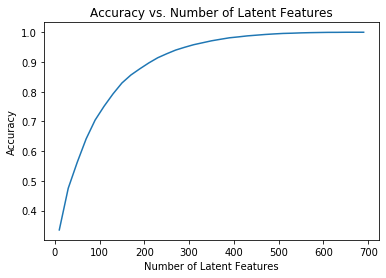

In [48]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
#df.shape[0] is the size of total data number. sum_errs is the difference in total data, so have to be devided by df.shape[0] 
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [49]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = list(user_item_test.index.values)
    test_arts = list(user_item_test.columns.get_level_values(1))
    return user_item_train, user_item_test, test_idx, test_arts


user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [50]:
user_item_test.shape

(682, 574)

In [51]:
#duplicated user ids and article ids in df_train and df_test
dup_user_item_test=user_item_train[user_item_train.index.isin(user_item_test.index)]
#artcilesid 
dup_user_item_test=dup_user_item_test.loc[:,user_item_train.columns.isin(user_item_test.columns)]

ans_1 = dup_user_item_test.shape[0] #number of users in test data and train data 20
ans_2 = (user_item_test.shape[0]-dup_user_item_test.shape[0])#SVD cannot recommend for new users
ans_3 = dup_user_item_test.shape[1] #we can make prediction for all test articles
ans_4 = user_item_test.shape[1]-dup_user_item_test.shape[1] #0
ans_1,ans_2,ans_3,ans_4

(20, 662, 574, 0)

In [52]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_test) # use the built in to get the three matrices
u.shape, s.shape, vt.shape 

((682, 682), (574,), (574, 574))

In [53]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [54]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below
u_train.shape,len(s_train),vt_train.shape

((4487, 4487), 714, (714, 714))

In [55]:
# common user row and article collumns index
user_row_idx = np.where(user_item_train.index.isin(user_item_test.index))[0]
article_col_idx = np.where(user_item_train.columns.isin(user_item_test.columns))[0]

In [56]:
#pick up related rows  u, vt
u_train_common = u_train[user_row_idx, : ]
vt_train_common = vt_train[ : ,article_col_idx]
u_train_common.shape,vt_train_common.shape

((20, 4487), (714, 574))

In [57]:
#Abstract table for compare with prediction
user_item_train_common_ids = user_item_train.iloc[user_row_idx].index.values
user_item_test_common = user_item_test[user_item_test.index.isin(user_item_train_common_ids)]
user_item_test_common.shape

(20, 574)

In [58]:
df_test.shape

(5993, 3)

In [59]:
num_test_data = df_test[df_test['user_id'].isin(user_item_train_common_ids)]
num_test_data.shape

(321, 3)

In [60]:
np.sum(np.sum(user_item_test_common))

218

In [61]:
def pred_accuracy_vs_latent_fetures_numbers(numrange,s,u,vt,user_item_to_compare,total_data_number):
    num_latent_feats = np.arange(1,numrange,1)
    sum_errs = []

    for k in num_latent_feats:
        # restructure with k latent features
        s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]

        # take dot product
        user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))

        # compute error for each prediction to actual value
        diffs = np.subtract(user_item_to_compare, user_item_est)

        # total errors and keep track of them
        err = np.sum(np.sum(np.abs(diffs)))
        #print("error=",err)
        #print("k=",k)
        sum_errs.append(err)
    #The total_data_number is count of the rows in the original df. The original df is which the user_item_to_compare made from.
    accuracy =  1 - np.array(sum_errs)/total_data_number
    plt.plot(num_latent_feats, accuracy);
    plt.xlabel('Number of Latent Features');
    plt.ylabel('Accuracy');
    plt.title('Accuracy vs. Number of Latent Features');
    return accuracy


In [62]:
user_item_test_common.shape

(20, 574)

In [63]:
u_train_common, s_train, vt_train_common = np.linalg.svd(user_item_test_common) # use the built in to get the three matrices
s_train.shape, u_train_common.shape, vt_train_common.shape

((20,), (20, 20), (574, 574))

In [64]:
#To calculate the accuracy, I think the error need to be devided by total number of the 1 and 0 in the table. 
#This is different with the original calculation which has given above.
total_1_0_number = user_item_test_common.shape[0]*user_item_test_common.shape[1]

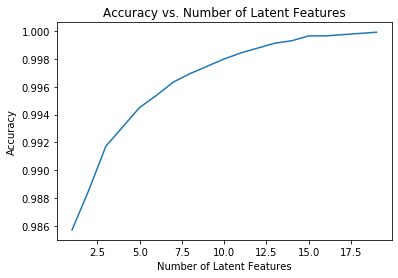

In [65]:
pred_accuracy_vs_latent_fetures_numbers(20,s_train, u_train_common, vt_train_common, user_item_test_common,total_1_0_number );

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Above figures show that prediction accuracy will be better with larger number of latent features in using SVD. The accuracy of the prediction is around 100% when we take 20 latent feature, this means we can make a prediction all of the listed alticles to a given user accurately. If a user currently find articles, we can use above recommendation systems to predict the interactions will be between the user with these articles. Because the recommendation system will recommend articles of top of large number of interactions, so we can see the predited interactions of articles that users currently found is equal or smaller than these recommended articles.This means the recommendations we made wih any of above recommendation systems are an improvement to how users currently find articles.**

<a id='conclusions'></a>

## Conclusion

I have 4 part of work in this report as blow.

##### I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
The dataset from IBM platform is:  
50% of individuals have 3 or fewer interactions.  
The total number of user-article interactions in the dataset is 45993.  
The maximum number of user-article interactions by any 1 user is 364.  
The most viewed article in the dataset was viewed 937 times.  
The article_id of the most viewed article is 1429.0.  
The number of unique articles that have at least 1 rating is 714.  
The number of unique users in the dataset is 5148.  
The number of unique articles on the IBM platform is 1051.  
##### II. [Rank Based Recommendations](#Rank)<br>  
Use the dataset, I made rank based recommendation systems to get top n number of articles.  

##### III. [User-User Based Collaborative Filtering](#User-User)<br>  
First of all, I made a user-item table. In the user-item table, if a user has interacted with an article, then place a 1 where the user-row meets for that article-column,if not, then place a zero where the user-row meets for that article-column. Second, I made a function to find neighbor users who has similar user-article interactions. The similarity was computed as the dot product of two users in user-item matrix. After this, I made recommendation article lists from neighbor users' interacted articles untill I get enough number of articles.  
To imporove the recommendation system, I made these 2 changes.  
1. Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.  
2. Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions.   

##### IV. [Matrix Factorization](#Matrix-Fact)<br>
I splited the original dataset into train-test dataset and fatorized the train dataset. I found that only 20 users but all of the 
articles in test-set I can make predictions because of the cold start problem. I also found that the more latent features I use the better accuracy I get to predict.the accuracy can balmost 100%.  
This means we can make a prediction all of the listed alticles to a given user accurately. If a user currently find articles, we can use above recommendation systems to predict the interactions will be between the user with these articles. Because the recommendation system will recommend articles of top of large number of interactions, so we can see the predited interactions of articles that users currently found is equal or smaller than these recommended articles.This means the recommendations we made wih any of above recommendation systems are an improvement to how users currently find articles.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [67]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0